In [1]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_c2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y.npy') #jacobian labels
y_short=np.load('/home/miquel/ForMiquel/CLEAN2/y_short.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id.npy') #jacobian idxs
sub_id_short=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt.npy') #subject idxs

In [5]:
def KFold_intern(X_train, y_train, folds, linspace, y_short_train, sub_id_train, sub_id_intern):
    
    l=len(linspace)
    l2=len(y_short_train)
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
        

    skf = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)   

    fold = 1
       
    for train_index_f, test_index_f in skf.split(sub_id_train, y_short_train):  
        aux = sub_id_train[train_index_f]
        idx = np.isin(sub_id_intern, aux)
#         print(idx)
        X_train_f = X_train[idx,:]
#         print(np.shape(X_train_f))
        X_test_f = X_train[~idx,:]
        y_train_f = y_train[idx]
#         print(np.shape(y_train_f))
        y_test_f = y_train[~idx]
        
        #print("fold:", fold)
        fold = fold + 1
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            #clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
            clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            #mask0 = np.where(dt_test_f>1.09)#~400 days
            #mask0 = np.asarray(mask0)
            #pred = pred[mask0][0]
            #y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    #plt.figure(1)
    #plt.plot(linspace, F, color='blue', label='F-measure')
    #plt.legend(loc='best')
    #plt.xlabel('C')
    #plt.title('metrics logistic regression combination c1 and c2')
    #plt.show()
    
    return maxi, maxi_idx

In [6]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, y_short, sub_id, sub_id_short, n):
   
    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    l2=X.shape[1]
    W=np.zeros((l2))
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(sub_id_short, y_short): #split in subjects
        sub_id_train = sub_id_short[train_index] #search subject train idxs
        idx = np.isin(sub_id, sub_id_train) #match train idxs 
        X_train = X[idx,:]
        X_test = X[~idx,:]
        y_train = y[idx]
        y_test = y[~idx]
        sub_id_intern=sub_id[idx]
        y_short_train=y_short[train_index]
        print("split:", split)
        #print("jacobians at train:", X_train.shape[0])
        split = split + 1
        
        clf = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')

        clf.fit(X_train, y_train)
        w = np.transpose(clf.coef_) #importance of each feature for classification
        w = np.reshape(w,l2)
        W = np.vstack((W, w))
        w=np.abs(w)
#         w = np.reshape(w,l2)
#         W = np.vstack((W, w)) #add weights of each split in W matrix
        #n=n.astype(int)
        idxs=w.argsort()[-n:][::-1]
        idxs=np.sort(idxs)      
        mask = np.zeros(l2, dtype=bool)
        mask[idxs]=True
        X_train_s = X_train[:,mask] #take columns of features with large (abs value) weights
        X_test_s = X_test[:,mask]
        
        maxi, maxi_idx = KFold_intern(X_train_s, y_train, folds, linspace, y_short_train, sub_id_train, sub_id_intern)
        c = linspace[maxi_idx]
        
        #clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        
        #mask0 = np.where(dt_test>1.09)#~400 days
        #mask0 = np.asarray(mask0)
        #pred = pred[mask0][0]
        #y_test = y_test[mask0][0]
        probas_ = probas_[:, 1]
        #probas_ = probas_[mask0][0]
        
        conf = confusion_matrix(y_test, pred)
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
#         print("specificity:", specificity)

    
    print("F_mean:", np.mean(F))
    print("AUC_mean:", np.mean(AUC))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    
    print("F_std:", np.std(F))
    print("AUC_std:", np.std(AUC))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    
    W=W[1:,:]
    W=np.sum(W, axis=0)
        
    path = '/home/miquel/ForMiquel/CLEAN2/W_' + str(splits) + '_' + str(n)
    np.save(path, W)
    
    
    #return F, AUC, PRECISION, RECALL, SPECIFICITY
    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY)


In [7]:
splits = 100
n = 2
folds= 3
linspace = np.linspace(10e-4, 10e-1, num=1)

F, AUC, PRECISION, RECALL, SPECIFICITY = nested_CV_F_measure(X, y, splits, folds, linspace, dt, y_short, sub_id, sub_id_short, n)


split: 1
split: 2
split: 3
split: 4
split: 5
split: 6
split: 7
split: 8
split: 9
split: 10
split: 11
split: 12
split: 13
split: 14
split: 15
split: 16
split: 17
split: 18
split: 19
split: 20
split: 21
split: 22
split: 23
split: 24
split: 25
split: 26
split: 27
split: 28
split: 29
split: 30
split: 31
split: 32
split: 33
split: 34
split: 35
split: 36
split: 37
split: 38
split: 39
split: 40
split: 41
split: 42
split: 43
split: 44
split: 45
split: 46
split: 47
split: 48
split: 49
split: 50
split: 51
split: 52
split: 53
split: 54
split: 55
split: 56
split: 57
split: 58
split: 59
split: 60
split: 61
split: 62
split: 63
split: 64
split: 65
split: 66
split: 67
split: 68
split: 69
split: 70
split: 71
split: 72
split: 73
split: 74
split: 75
split: 76
split: 77
split: 78
split: 79
split: 80
split: 81
split: 82
split: 83
split: 84
split: 85
split: 86
split: 87
split: 88
split: 89
split: 90
split: 91
split: 92
split: 93
split: 94
split: 95
split: 96
split: 97
split: 98
split: 99
split: 100
F_mean: 

In [10]:
W=np.load('/home/miquel/ForMiquel/CLEAN2/W_100_2.npy') 
# aux = np.sum(W, axis=0)
aux=W
zero_cols=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_c2.npy')
v = np.zeros((121*145*121,)) 
v[~zero_cols]=np.reshape(aux,(len(aux),)) #put pvalues in corresponding positions
img = np.reshape(v, (121,145,121)) #reshape to original image shape
img = np.transpose(img)
np.save('/home/miquel/ForMiquel/CLEAN2/W_NEGATIVES', img)
new_img = nib.Nifti1Image(img, np.eye(4))
nib.save(new_img, "W_NEGATIVES_img.nii.gz")



## strategy 2 per jacobian

In [2]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt_full2.npy')

#X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_1y.npy') 
#y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_1y.npy') #subject labels
#sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_idx_1j_1y.npy') #subject idxs
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_1y.npy')

In [3]:
def KFold_intern(X_train, y_train, folds, linspace, dt):
    
    l=len(linspace)
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
        

    skf = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)   

    fold = 1
       
    for train_index_f, test_index_f in skf.split(X_train, y_train):  
        X_train_f = X_train[train_index_f,:]
        X_test_f = X_train[test_index_f,:]
        y_train_f = y_train[train_index_f]
        y_test_f = y_train[test_index_f]
        
        print("fold:", fold)
        fold = fold + 1
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            #clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
            clf = LogisticRegression(solver='liblinear', penalty='l1', C=c, class_weight='balanced')
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            #mask0 = np.where(dt_test_f>1.09)#~400 days
            #mask0 = np.asarray(mask0)
            #pred = pred[mask0][0]
            #y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    #plt.figure(1)
    #plt.plot(linspace, F, color='blue', label='F-measure')
    #plt.legend(loc='best')
    #plt.xlabel('C')
    #plt.title('metrics logistic regression combination c1 and c2')
    #plt.show()
    
    return maxi, maxi_idx

In [4]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, n):
   
    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    ACCURACY=[]
    
    SPECIFICITY1=[]
    PRECISION1=[]
    RECALL1=[]
    AUC1=[]
    F1=[]
    ACCURACY1=[]
    
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    l2=X.shape[1]
    W=np.zeros((l2))
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        
        print("split:", split)
        split = split + 1
        
        clf = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')

        clf.fit(X_train, y_train)
        w = np.transpose(clf.coef_) #importance of each feature for classification
        w=np.abs(w)
        w = np.reshape(w,l2)
        W = np.vstack((W, w)) #add weights of each split in W matrix
        #n=n.astype(int)
        idxs=w.argsort()[-n:][::-1]
        idxs=np.sort(idxs)      
        mask = np.zeros(l2, dtype=bool)
        mask[idxs]=True
        X_train_s = X_train[:,mask] #take columns of features with large (abs value) weights
        X_test_s = X_test[:,mask]
        
        maxi, maxi_idx = KFold_intern(X_train_s, y_train, folds, linspace, dt)
        c = linspace[maxi_idx]
        print("c:", c)
        
        #clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        
        #mask0 = np.where(dt_test>1.09)#~400 days
        #mask0 = np.asarray(mask0)
        #pred = pred[mask0][0]
        #y_test = y_test[mask0][0]
        probas_ = probas_[:, 1]
        #probas_ = probas_[mask0][0]
        
                
        #preparation masks to test AUC as function of dt
        mask1 = np.where(dt_test>1.15)#~400 days
        mask1 = np.asarray(mask1)
        pred_1 = pred[mask1][0]
        y_test_1 = y_test[mask1][0]
        probas_1 = probas_[mask1][0]
        
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        
        f1_1=f1_score(y_test_1, pred_1)
        if np.isnan(f1_1) == False:
            F1.append(f1_1)
        
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_1)
        roc_auc_1 = sklearn.metrics.auc(fpr, tpr)
        if np.isnan(roc_auc_1) == False:
            AUC1.append(roc_auc_1)

        
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
        acc=accuracy_score(y_test, pred)
        ACCURACY.append(acc)
        
        precision1=precision_score(y_test_1, pred_1)
        recall1=recall_score(y_test_1, pred_1)
        PRECISION1.append(precision1)
        RECALL1.append(recall1)
        conf1 = confusion_matrix(y_test_1, pred_1)
        specificity1= (conf1[0,0])/(conf1[0,0]+conf1[0,1])
        SPECIFICITY1.append(specificity1)
        acc1=accuracy_score(y_test_1, pred_1)
        ACCURACY1.append(acc1)
        
    
    #box = np.transpose(box)
    #np.save('/home/miquel/ForMiquel/CLEAN2/Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y', box)
    #new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, 'img_Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y.nii.gz')
    
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)
    

    print("ACCURACY_mean:", np.mean(ACCURACY))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    print("F_mean:", np.mean(F))
    print("AUC_mean:", np.mean(AUC))
    
    print("ACCURACY1_mean:", np.mean(ACCURACY1))
    print("PRECISION1_mean:", np.mean(PRECISION1))
    print("RECALL1_mean:", np.mean(RECALL1))
    print("SPECIFICITY1_mean:", np.mean(SPECIFICITY1))
    print("F1_mean:", np.mean(F1))
    print("AUC1_mean:", np.mean(AUC1))

    print("ACCURACY_std:", np.std(ACCURACY))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    print("F_std:", np.std(F))
    print("AUC_std:", np.std(AUC))

    print("ACCURACY1_std:", np.std(ACCURACY1))
    print("PRECISION1_std:", np.std(PRECISION1))
    print("RECALL1_std:", np.std(RECALL1))
    print("SPECIFICITY1_std:", np.std(SPECIFICITY1))
    print("F1_std:", np.std(F1))
    print("AUC1_std:", np.std(AUC1))

    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY), np.mean(ACCURACY), np.std(F), np.std(AUC), np.std(PRECISION), np.std(RECALL), np.std(SPECIFICITY), np.std(ACCURACY),np.mean(F1), np.mean(AUC1), np.mean(PRECISION1), np.mean(RECALL1), np.mean(SPECIFICITY1), np.mean(ACCURACY1), np.std(F1), np.std(AUC1), np.std(PRECISION1), np.std(RECALL1), np.std(SPECIFICITY1), np.std(ACCURACY1)


In [9]:
splits = 100
folds = 3
percentages = np.linspace(10 , 4500, 20)
linspace = np.linspace(10e-3, 10e3, num=10)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]
accuracy=[]

f_s=[]
auc_s=[]
precision_s=[]
recall_s=[]
specificity_s=[]
accuracy_s=[]

f1=[]
auc1=[]
precision1=[]
recall1=[]
specificity1=[]
accuracy1=[]

f1_s=[]
auc1_s=[]
precision1_s=[]
recall1_s=[]
specificity1_s=[]
accuracy1_s=[]


for per in percentages:
    print("percentage:", per)
    per = int(per)
    F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, per)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)
    accuracy.append(ACCURACY)
    
    f_s.append(Fs)
    auc_s.append(AUCs)
    precision_s.append(PRECISIONs)
    recall_s.append(RECALLs)
    specificity_s.append(SPECIFICITYs)
    accuracy_s.append(ACCURACYs)
    
    f1.append(F1)
    auc1.append(AUC1)
    precision1.append(PRECISION1)
    recall1.append(RECALL1)
    specificity1.append(SPECIFICITY1)
    accuracy1.append(ACCURACY1)
    
    f1_s.append(F1s)
    auc1_s.append(AUC1s)
    precision1_s.append(PRECISION1s)
    recall1_s.append(RECALL1s)
    specificity1_s.append(SPECIFICITY1s)
    accuracy1_s.append(ACCURACY1s)
    

    

percentage: 10.0
split: 1
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 2
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 3
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 4
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 5
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 6
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 7
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 8
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 9
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 10
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 11
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 12
fold: 1
fold: 2
fold: 3
c: 2222.23
split: 13
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 14
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 15
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 16
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 17
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 18
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 19
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 20
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 21
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 22
fold: 1
fold: 2
fold: 3
c: 1111.12
sp

split: 68
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 69
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 70
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 71
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 72
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 73
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 74
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 75
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 76
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 77
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 78
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 79
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 80
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 81
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 82
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 83
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 84
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 85
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 86
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 87
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 88
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 89
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 90


split: 19
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 20
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 21
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 22
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 23
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 24
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 25
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 26
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 27
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 28
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 29
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 30
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 31
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 32
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 33
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 34
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 35
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 36
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 37
fold: 1
fold: 2
fold: 3
c: 2222.23
split: 38
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 39
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 40
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 41


fold: 3
c: 10000.0
split: 86
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 87
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 88
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 89
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 90
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 91
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 92
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 93
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 94
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 95
fold: 1
fold: 2
fold: 3
c: 1111.12
split: 96
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 97
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 98
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 99
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 100
fold: 1
fold: 2
fold: 3
c: 6666.67
ACCURACY_mean: 0.687105263158
PRECISION_mean: 0.639263611088
RECALL_mean: 0.508
SPECIFICITY_mean: 0.803913043478
F_mean: 0.557422231693
AUC_mean: 0.685304347826
ACCURACY1_mean: 0.713039281297
PRECISION1_mean: 0.660983100233
RECALL1_mean: 0.652531191031
SPECIFICITY1_mean: 0.75748591467
F1_mean: 0.64011311

split: 37
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 38
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 39
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 40
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 41
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 42
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 43
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 44
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 45
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 46
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 47
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 48
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 49
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 50
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 51
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 52
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 53
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 54
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 55
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 56
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 57
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 58
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 59


percentage: 1900.52631579
split: 1
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 2
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 3
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 4
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 5
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 6
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 7
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 8
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 9
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 10
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 11
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 12
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 13
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 14
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 15
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 16
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 17
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 18
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 19
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 20
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 21
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 22
fold: 1
fold: 2
fold: 3
c: 7

fold: 3
c: 8888.89
split: 68
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 69
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 70
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 71
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 72
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 73
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 74
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 75
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 76
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 77
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 78
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 79
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 80
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 81
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 82
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 83
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 84
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 85
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 86
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 87
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 88
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 89
fold: 1
fold: 2
fold: 3
c:

fold: 3
c: 8888.89
split: 19
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 20
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 21
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 22
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 23
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 24
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 25
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 26
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 27
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 28
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 29
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 30
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 31
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 32
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 33
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 34
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 35
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 36
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 37
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 38
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 39
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 40
fold: 1
fold: 2
fold: 3
c:

fold: 2
fold: 3
c: 10000.0
split: 86
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 87
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 88
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 89
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 90
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 91
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 92
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 93
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 94
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 95
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 96
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 97
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 98
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 99
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 100
fold: 1
fold: 2
fold: 3
c: 8888.89
ACCURACY_mean: 0.685
PRECISION_mean: 0.647735935762
RECALL_mean: 0.472666666667
SPECIFICITY_mean: 0.82347826087
F_mean: 0.539008201123
AUC_mean: 0.667217391304
ACCURACY1_mean: 0.710888546175
PRECISION1_mean: 0.664861083361
RECALL1_mean: 0.629725413475
SPECIFICITY1_mean: 0.76998303743
F1_mean: 0.6

c: 4444.45
split: 37
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 38
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 39
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 40
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 41
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 42
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 43
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 44
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 45
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 46
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 47
fold: 1
fold: 2
fold: 3
c: 2222.23
split: 48
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 49
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 50
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 51
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 52
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 53
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 54
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 55
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 56
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 57
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 58
fold: 1
fold: 2
fold: 3
c: 7777.78

percentage: 3791.05263158
split: 1
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 2
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 3
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 4
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 5
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 6
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 7
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 8
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 9
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 10
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 11
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 12
fold: 1
fold: 2
fold: 3
c: 5555.56
split: 13
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 14
fold: 1
fold: 2
fold: 3
c: 2222.23
split: 15
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 16
fold: 1
fold: 2
fold: 3
c: 4444.45
split: 17
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 18
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 19
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 20
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 21
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 22
fold: 1
fold: 2
fold: 3
c: 7

fold: 2
fold: 3
c: 10000.0
split: 68
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 69
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 70
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 71
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 72
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 73
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 74
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 75
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 76
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 77
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 78
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 79
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 80
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 81
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 82
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 83
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 84
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 85
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 86
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 87
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 88
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 89
fold: 1
fold: 2
fo

split: 19
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 20
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 21
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 22
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 23
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 24
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 25
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 26
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 27
fold: 1
fold: 2
fold: 3
c: 3333.34
split: 28
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 29
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 30
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 31
fold: 1
fold: 2
fold: 3
c: 8888.89
split: 32
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 33
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 34
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 35
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 36
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 37
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 38
fold: 1
fold: 2
fold: 3
c: 7777.78
split: 39
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 40
fold: 1
fold: 2
fold: 3
c: 6666.67
split: 41


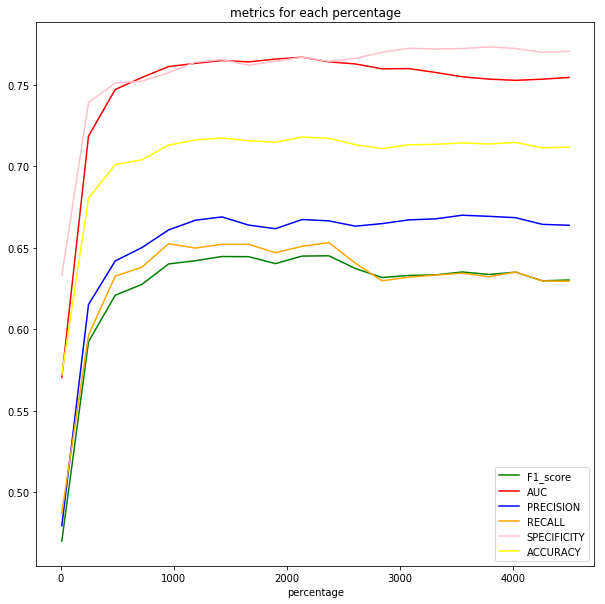

In [10]:
plt.figure(figsize=(10,10))
plt.plot(percentages, f1, color='green', label='F1_score')
plt.plot(percentages, auc1, color='red', label='AUC')
plt.plot(percentages, precision1, color='blue', label='PRECISION')
plt.plot(percentages, recall1, color='orange', label='RECALL')
plt.plot(percentages, specificity1, color='pink', label='SPECIFICITY')
plt.plot(percentages, accuracy1, color='yellow', label='ACCURACY')

plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  

In [11]:
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_2', f)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_2', auc)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_2', precision)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_2', recall)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_2', specificity)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_2', accuracy)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_s_2', f_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_s_2', auc_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_s_2', precision_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_s_2', recall_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_s_2', specificity_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_s_2', accuracy_s)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_2', f1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_2', auc1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_2', precision1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_2', recall1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_2', specificity1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_2', accuracy1)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_s_2', f1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_s_2', auc1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_s_2', precision1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_s_2', recall1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_s_2', specificity1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_s_2', accuracy1_s)


In [8]:
splits = 100
n = 3035
folds= 3
linspace = np.linspace(10e-2, 10e3, num=20)

F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, n)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

split: 1
fold: 1
fold: 2
fold: 3
c: 10000.0
split: 2
fold: 1
fold: 2
fold: 3
c: 6842.13684211
split: 3
fold: 1
fold: 2
fold: 3
c: 9473.68947368
split: 4
fold: 1
fold: 2
fold: 3
c: 6842.13684211
split: 5
fold: 1
fold: 2
fold: 3
c: 9473.68947368
split: 6


KeyboardInterrupt: 

In [15]:
W=np.load('/home/miquel/ForMiquel/CLEAN2/W_jacobian_100_5000_1y.npy') 
zero_cols=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_1j_1y.npy')
v = np.zeros((121*145*121,)) 
v[~zero_cols]=np.reshape(W,(len(W),)) #put pvalues in corresponding positions
img = np.reshape(v, (121,145,121)) #reshape to original image shape
img = np.transpose(img)
np.save('/home/miquel/ForMiquel/CLEAN2/W_jacobian_100_5000_1y', img)
new_img = nib.Nifti1Image(img, np.eye(4))
nib.save(new_img, "W_jacobian_100_5000_1y_img.nii.gz")

In [6]:
np.shape(X)

(124, 572738)